# AlexNet For ImageNet Dataset

In this notebook, we implemented a model based on the AlexNet architecture using TensorFlow, and trained it on the ImageNet dataset, which contains 1,000 classes.

We began with some exploratory data analysis (EDA) and visualization to understand the dataset structure and determine the appropriate preprocessing steps.

## Importing Libraries

In [3]:
import tensorflow as tf
import numpy as np
import warnings
import random
import os
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [26]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## EDA & Visualizing Random Pics

In [17]:
DATA_PATH = "/kaggle/input/imagenet-256"

The dataset contains 1,000 classes, but the number of images per class is **imbalanced**. Some classes contain up to 1,000 images, while others have as few as 100–500. This imbalance may affect training performance and generalization.

In [32]:
count = 0

for dirpath, dirname, filename in os.walk(DATA_PATH):
    print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")
    count += 1
    if count >= 100:
        break

There are 1000 directories and 0 images in '/kaggle/input/imagenet-256'.
There are 0 directories and 369 images in '/kaggle/input/imagenet-256/entertainment_center'.
There are 0 directories and 419 images in '/kaggle/input/imagenet-256/bobsled'.
There are 0 directories and 507 images in '/kaggle/input/imagenet-256/pencil_sharpener'.
There are 0 directories and 530 images in '/kaggle/input/imagenet-256/projector'.
There are 0 directories and 506 images in '/kaggle/input/imagenet-256/microphone'.
There are 0 directories and 277 images in '/kaggle/input/imagenet-256/wire_haired_fox_terrier'.
There are 0 directories and 428 images in '/kaggle/input/imagenet-256/rugby_ball'.
There are 0 directories and 274 images in '/kaggle/input/imagenet-256/black_grouse'.
There are 0 directories and 423 images in '/kaggle/input/imagenet-256/oboe'.
There are 0 directories and 684 images in '/kaggle/input/imagenet-256/american_lobster'.
There are 0 directories and 530 images in '/kaggle/input/imagenet-256/

Visualizing Random Images Per Class

In [36]:
def visualize_random_images(data_path, num_classes=5, num_images_per_class=5):
    classes = [c for c in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, c))]
    selected_classes = random.sample(classes, num_classes)

    plt.figure(figsize=(15, num_classes * 2.5))

    for i, cls in enumerate(selected_classes):
        cls_path = os.path.join(data_path, cls) /kaggle/input/imagenet-256/abacus
        image_files = os.listdir(cls_path)
        selected_images = random.sample(image_files, min(num_images_per_class, len(image_files)))

        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(cls_path, img_name)
            try:
                img = mpimg.imread(img_path)
                plt.subplot(num_classes, num_images_per_class, i * num_images_per_class + j + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(cls[:12])
            except Exception as e:
                print(f"Could not read {img_path}: {e}")

    plt.tight_layout()
    plt.show()

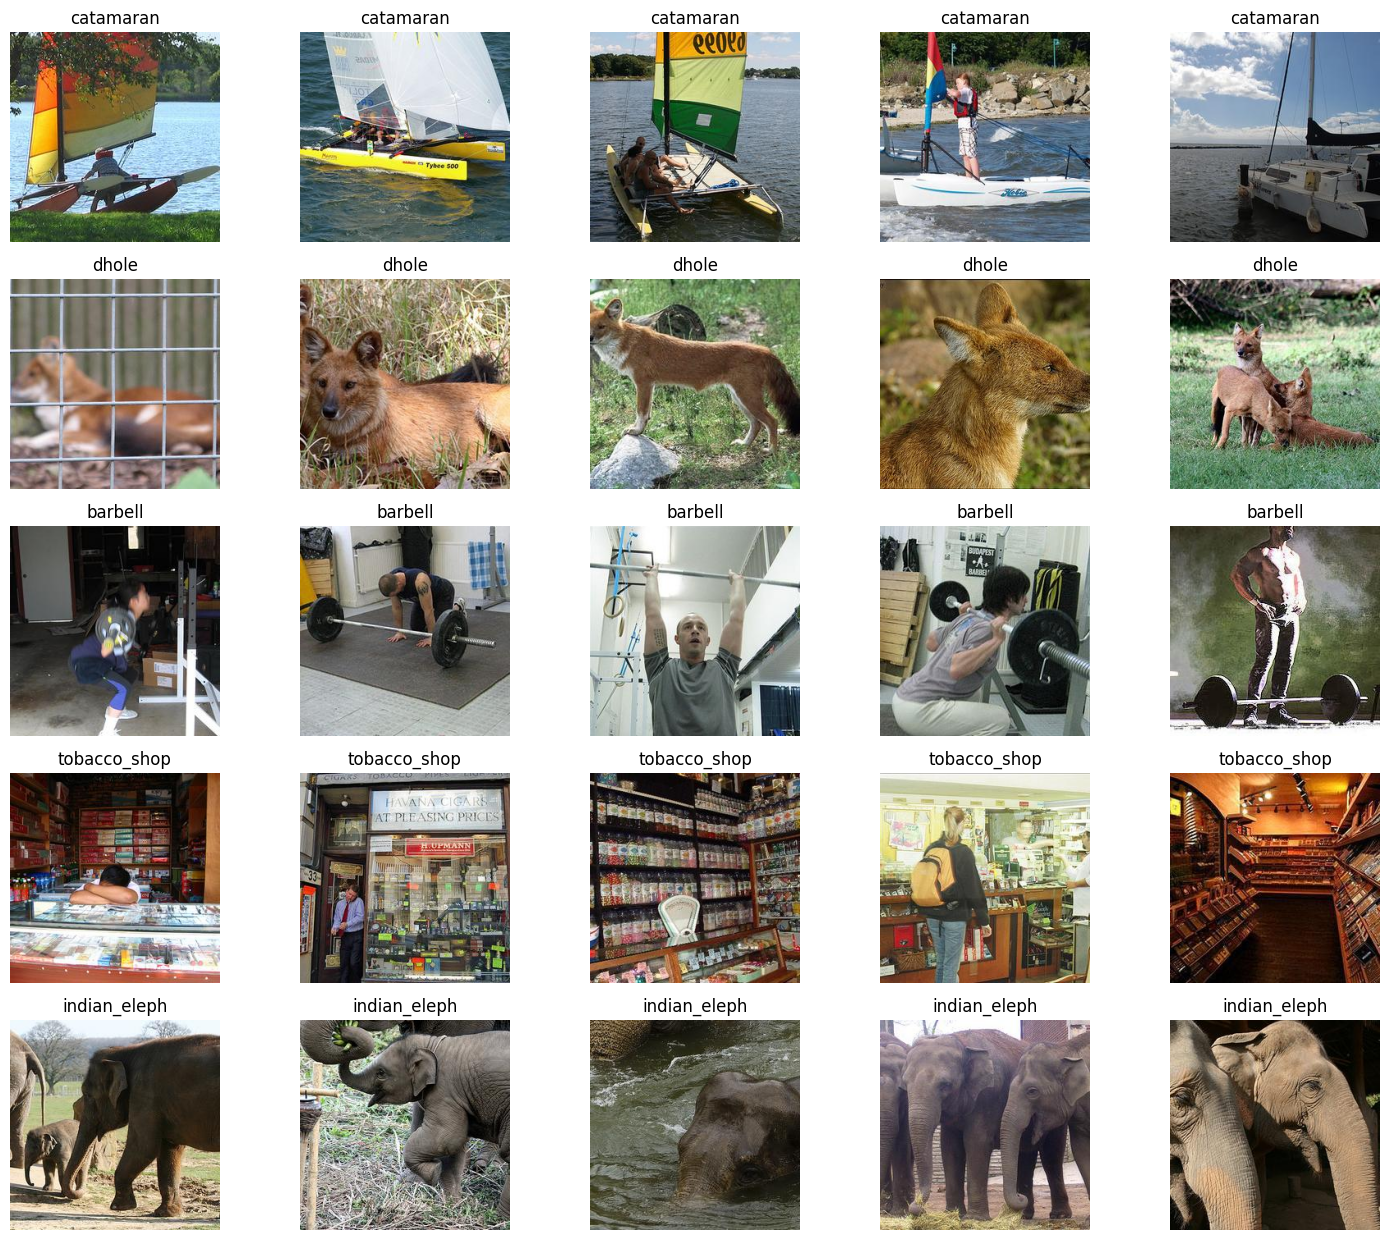

In [40]:
visualize_random_images(DATA_PATH)

## Getting The Data Ready

### Splitting The Data

We considered two main approaches for splitting the data. The first was using a **for loop** to explicitly create train, val, and test subfolders and manually copy a random set of images from each class according to a specific split ratio. We initially leaned toward this method because it gave us full control, especially for preparing a test set that the model would only see once.

However, this approach turned out to be time-consuming and inefficient, particularly with a large dataset. So instead, we opted for the much faster and more scalable **image_dataset_from_directory** method in TensorFlow, which handles training and validation splitting automatically. As for the test set, we decided to create it manually later from unseen data to maintain its integrity.

To speed up training, we used a **batch_size of 256**, which reduces the number of steps per epoch compared to using smaller sizes like 32, 64, or 128.

In [57]:
#splitting the data (0.8,0.2) 
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(227, 227), 
    batch_size=256,
    shuffle=True
) 

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(227, 227),
    batch_size=256,
    shuffle=False
)

Found 539826 files belonging to 1000 classes.
Using 431861 files for training.
Found 539826 files belonging to 1000 classes.
Using 107965 files for validation.


### Normalization
We used a Rescaling layer to normalize pixel values from [0, 255] to [0, 1].
It was applied to both training and validation sets using map(), followed by prefetch() for performance.

In [58]:
normalization_layer = tf.keras.layers.Rescaling(1./255) #normalization
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

#prefetch
train_ds = train_ds.prefetch(tf.data.AUTOTUNE) 
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

### Balancing & augmentation
We initially considered **balancing** the training set only to avoid bias and preserve a natural class distribution in validation. However, it was time-inefficient, so we postponed it to after building the baseline model, in case class imbalance isn’t a major issue.

Similarly, we considered data **augmentation** to reduce overfitting, but decided to revisit it later after evaluating the model’s initial performance

## Building The Baseline Model
We implemented the **standard AlexNet** architecture, preserving its original structure with 5 convolutional layers followed by 3 fully connected layers. We included **Batch Normalization** after the first two convolutional layers to help stabilize and speed up training. Additionally, we applied **Dropout layers** (0.5) after the first two fully connected layers to reduce overfitting.

In [23]:
model = models.Sequential()

#input layer + conv layer1
model.add(layers.Conv2D(96, kernel_size=11, strides=4, activation='relu', input_shape=(227, 227, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=3, strides=2))

#conv layer2
model.add(layers.Conv2D(256, kernel_size=5, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=3, strides=2))

#conv layers 3,4,5
model.add(layers.Conv2D(384, kernel_size=3, padding='same', activation='relu'))
model.add(layers.Conv2D(384, kernel_size=3, padding='same', activation='relu'))
model.add(layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'))

#final pooling + flatten
model.add(layers.MaxPooling2D(pool_size=3, strides=2))
model.add(layers.Flatten())

#fully connected layers + dropouts
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))

#output layer(1k classes)
model.add(layers.Dense(1000, activation='softmax'))

In [27]:
#checkpoint callback
checkpoint = ModelCheckpoint("/kaggle/working/model_epoch_{epoch:02d}_valacc_{val_accuracy:.2f}.h5", save_best_only=True, monitor="val_accuracy", mode="max")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
#baseline model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint]
)

Epoch 1/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 361s 206ms/step - accuracy: 0.0199 - loss: 6.3259 - val_accuracy: 0.0814 - val_loss: 5.1951
Epoch 2/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 348s 206ms/step - accuracy: 0.1307 - loss: 4.5918 - val_accuracy: 0.0533 - val_loss: 5.9693
Epoch 3/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 345s 204ms/step - accuracy: 0.2175 - loss: 3.8807 - val_accuracy: 0.0500 - val_loss: 6.2093
Epoch 4/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 348s 206ms/step - accuracy: 0.2854 - loss: 3.4097 - val_accuracy: 0.2349 - val_loss: 4.0664
Epoch 5/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 353s 209ms/step - accuracy: 0.3411 - loss: 3.0456 - val_accuracy: 0.2626 - val_loss: 3.8856
Epoch 6/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 363s 215ms/step - accuracy: 0.3911 - loss: 2.7329 - val_accuracy: 0.1797 - val_loss: 4.4707
Epoch 7/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 345s 204ms/step - accuracy: 0.4380 - loss: 2.4588 - val_accuracy: 0.1580 - val_loss: 5.2420
Epoch 8/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 349s 206ms/step - ac

**Overfitting** began at epoch 6, validation accuracy started dropping while training accuracy continued to increase. To address this, we will load the best model checkpoint from this experiment, add a data augmentation layer, and continue training from where it left off.

Experiment 2: Augmentation layer + early stopping

In [53]:
#adding aug layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
], name="augmentation_layer")

model_aug = models.Sequential([
    data_augmentation,
    
    #alexnet layers:
    layers.Conv2D(96, kernel_size=11, strides=4, activation='relu', input_shape=(227, 227, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=3, strides=2),
    
    layers.Conv2D(256, kernel_size=5, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=3, strides=2),
    
    layers.Conv2D(384, kernel_size=3, padding='same', activation='relu'),
    layers.Conv2D(384, kernel_size=3, padding='same', activation='relu'),
    layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=3, strides=2),
    
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation='softmax')
])

In [54]:
#adding early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

callbacks = [early_stopping, ModelCheckpoint("/kaggle/working/modelaug_epoch_{epoch:02d}_valacc_{val_accuracy:.2f}.h5", save_best_only=True, monitor="val_accuracy")]

In [55]:
model_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [59]:
history_aug = model_aug.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks)

Epoch 1/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 416s 247ms/step - accuracy: 0.0194 - loss: 6.3642 - val_accuracy: 0.0855 - val_loss: 5.2130
Epoch 2/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 407s 241ms/step - accuracy: 0.1078 - loss: 4.8929 - val_accuracy: 0.1764 - val_loss: 4.3529
Epoch 3/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 407s 241ms/step - accuracy: 0.1762 - loss: 4.2489 - val_accuracy: 0.2564 - val_loss: 3.6792
Epoch 4/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 409s 243ms/step - accuracy: 0.2291 - loss: 3.8334 - val_accuracy: 0.2643 - val_loss: 3.6589
Epoch 5/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 408s 242ms/step - accuracy: 0.2706 - loss: 3.5286 - val_accuracy: 0.2842 - val_loss: 3.4876
Epoch 6/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 408s 242ms/step - accuracy: 0.3039 - loss: 3.2905 - val_accuracy: 0.3465 - val_loss: 3.1195
Epoch 7/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 408s 242ms/step - accuracy: 0.3325 - loss: 3.1016 - val_accuracy: 0.3741 - val_loss: 2.9263
Epoch 8/10
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 409s 242ms/step - ac

Everything looks stable for now, so we will continue training the model for 10 more epochs. Although the model appears to be handling the training well and could potentially run for 50–100 epochs in total, we dont think it's ideal to train that many in a single run due to the long execution time per epoch. For efficiency and control, we prefer to train in smaller segments and monitor progress between each run

In [61]:
history_aug_2 = model_aug.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    initial_epoch=10,
    callbacks=callbacks
)

Epoch 11/20
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 432s 256ms/step - accuracy: 0.4180 - loss: 2.5756 - val_accuracy: 0.4168 - val_loss: 2.6433
Epoch 12/20
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 404s 240ms/step - accuracy: 0.4355 - loss: 2.4780 - val_accuracy: 0.4678 - val_loss: 2.3825
Epoch 13/20
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 408s 242ms/step - accuracy: 0.4481 - loss: 2.3941 - val_accuracy: 0.4948 - val_loss: 2.2348
Epoch 14/20
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 403s 239ms/step - accuracy: 0.4617 - loss: 2.3159 - val_accuracy: 0.4891 - val_loss: 2.2756
Epoch 15/20
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 405s 240ms/step - accuracy: 0.4749 - loss: 2.2429 - val_accuracy: 0.4974 - val_loss: 2.2097
Epoch 16/20
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 404s 239ms/step - accuracy: 0.4878 - loss: 2.1757 - val_accuracy: 0.5284 - val_loss: 2.0646
Epoch 17/20
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 407s 241ms/step - accuracy: 0.4982 - loss: 2.1159 - val_accuracy: 0.4714 - val_loss: 2.3699
Epoch 18/20
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 411s 243ms/s

It's normal for val_accuracy to be higher than training accuracy, especially when using Dropout and Data Augmentation. These techniques only apply during training, which makes training harder, while validation is evaluated on clean data.
This is not overfitting, it's expected behavior.

In [63]:
history_aug_3 = model_aug.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    initial_epoch=20,
    callbacks=callbacks
)

Epoch 21/30
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 414s 245ms/step - accuracy: 0.5273 - loss: 1.9529 - val_accuracy: 0.5781 - val_loss: 1.8537
Epoch 22/30
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 407s 241ms/step - accuracy: 0.5357 - loss: 1.9058 - val_accuracy: 0.5927 - val_loss: 1.7840
Epoch 23/30
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 414s 245ms/step - accuracy: 0.5457 - loss: 1.8603 - val_accuracy: 0.5951 - val_loss: 1.7524
Epoch 24/30
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 412s 244ms/step - accuracy: 0.5520 - loss: 1.8173 - val_accuracy: 0.6486 - val_loss: 1.5277
Epoch 25/30
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 410s 243ms/step - accuracy: 0.5595 - loss: 1.7819 - val_accuracy: 0.5553 - val_loss: 1.9549
Epoch 26/30
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 411s 244ms/step - accuracy: 0.5664 - loss: 1.7432 - val_accuracy: 0.5975 - val_loss: 1.7262
Epoch 27/30
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 414s 245ms/step - accuracy: 0.5730 - loss: 1.7039 - val_accuracy: 0.6664 - val_loss: 1.4432
Epoch 28/30
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 414s 245ms/s

## Histories Comparisons

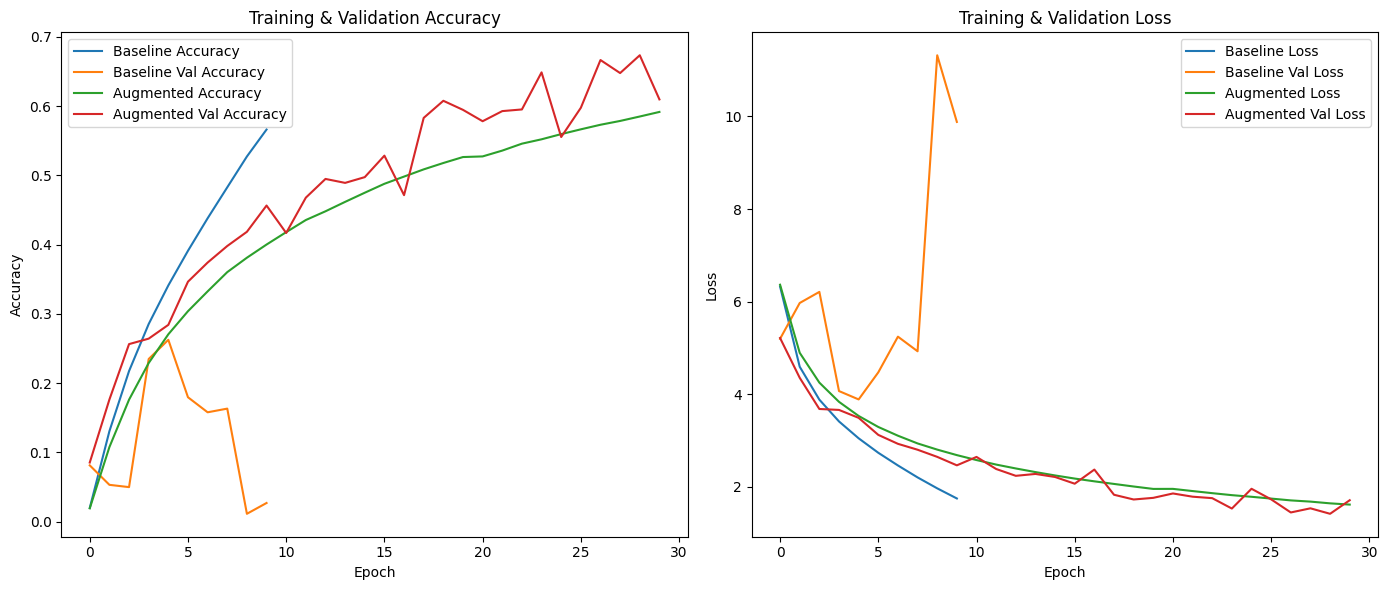

In [2]:
# Combine augmented histories
aug_accuracy = history_aug.history["accuracy"] + history_aug_2.history["accuracy"] + history_aug_3.history["accuracy"]
aug_val_accuracy = history_aug.history["val_accuracy"] + history_aug_2.history["val_accuracy"] + history_aug_3.history["val_accuracy"]
aug_loss = history_aug.history["loss"] + history_aug_2.history["loss"] + history_aug_3.history["loss"]
aug_val_loss = history_aug.history["val_loss"] + history_aug_2.history["val_loss"] + history_aug_3.history["val_loss"]

plt.figure(figsize=(14, 6))

#accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Baseline Train Acc")
plt.plot(history.history["val_accuracy"], label="Baseline Val Acc")
plt.plot(aug_accuracy, label="Augmented Train Acc")
plt.plot(aug_val_accuracy, label="Augmented Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

#loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Baseline Train Loss")
plt.plot(history.history["val_loss"], label="Baseline Val Loss")
plt.plot(aug_loss, label="Augmented Train Loss")
plt.plot(aug_val_loss, label="Augmented Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


## Switching to a New Notebook
Due to Kaggle's 12-hour session limit, we are continuing the training in a new notebook. To resume smoothly, we:

- Saved the full model (.h5) including weights, architecture, and optimizer state and it's history.

- Will re-load the dataset and apply the same preprocessing (normalization, augmentation).

- Will load the saved model and resume training using initial_epoch.

In [64]:
model_aug.save("/kaggle/working/full_model_aug.h5")

In [5]:
def save_history(history, filename):
    with open(filename, 'w') as f:
        json.dump(history.history, f)


save_history(history_aug, "aug_history_1.json")
save_history(history_aug_2, "aug_history_2.json")
save_history(history_aug_3, "aug_history_3.json")